In [284]:
import numpy as np
import pandas as pd
import chardet
from datetime import date
from scipy.stats import norm
from scipy.stats import chi2
import matplotlib.pyplot as plt

## 1. Чтение, обработка данных

In [9]:
data = pd.read_csv('C:/Users/User/Desktop/Study/Scientific_work/globalterrorismdb_0718dist.csv', encoding='ISO-8859-1', low_memory=False)
print("Input data shape: " , data.shape)

Input data shape:  (181691, 135)


In [10]:
data = data.drop(data.iloc[:, 9:],  axis=1)
data = data.drop(data.columns[[0, 4, 5, 6]], axis = 1)
#data["country_txt"] == "Russia") |
df_russia = data[ (data["country_txt"] == "Russia") | (data["country_txt"] == "Soviet Union")  ] 
print("Data for Russia shape: " , df_russia.shape)

Data for Russia shape:  (2272, 5)


In [362]:
def compute_and_add_days(df, name):
    
    n_cols = df.shape[1]
    n_rows = df.shape[0]
    ret = df;
    uncorrects = [[] , 0];
    row_days = []
    row0 = df.loc[0];
    start = date(row0[0], row0[1], row0[2])
    
    for i in range(0, n_rows):   
        row = ret.loc[i]
        #print("process ", i)
        if ((row[2] < 1) or (row[2] > 31)): #or (row[1] < 1) or (row[1] > 12)):
            #uncorrects[0].append(row)
            #uncorrects[1] += 1
            ret = ret.drop(i, axis = 0)
            #print(" drop " , i)
            continue 
            
        curr = date(row[0], row[1], row[2])
        row_days.append((curr - start).days)
        
    ret[name] = row_days
    ret = ret.reset_index(drop = True)
    
    ret = ret.sort_values(by=[name])
    return ret

In [363]:
df_size = df_russia.shape[0];
df_russia = df_russia.reset_index(drop = True)
#print(df_russia.iloc[:50])
#df_russia = df_russia.drop([0, 1], axis = 0)
#print(df_russia.iloc[:10])
df_russia = compute_and_add_days(df_russia, "days from start")
print("Preprocess data for Russia, with days from start, shape: " , df_russia.shape)


Preprocess data for Russia, with days from start, shape:  (2267, 6)


## 2. Разбиение данных на две выборки по времени и по колличеству заявок в промежутках времени

In [347]:
def first_method_reduce(df, step):
    n_cols = df.shape[1]
    n_rows = df.shape[0]
    
    ret = []
    i = 0
    while (i <= (n_rows - 2)):
        row = [df.loc[i][n_cols - 1], i]
        while ((df.loc[i + 1][n_cols - 1] - df.loc[i][n_cols - 1] <= step) and (i < (n_rows - 2))):
            i += 1
        i += 1
        ret.append([row[0], i - row[1]])
    ret[-1][1] += 1
    ret = np.array(ret)
    return (ret)

In [364]:
step = 10;
reduce = first_method_reduce(df_russia, step)
print("Reduce data for Russia, with days from start, shape: " , len(reduce))
time_arr = np.diff(reduce[:,0])
requests = reduce[:, 1]
print("time intervals = ")
print(time_arr)
print("requests = ")
print(requests)

Reduce data for Russia, with days from start, shape:  240
time intervals = 
[4120   97   30   22   18   92   45   34   19   16   28   14   33   17
   64  110   25   21   12   39   25   24   25   12   23   61   31   54
   11   20   37   13   73   21   70   19   14  451   40   25   22   40
   47   19   60   20   13   67   13   55   28   35   35   24   34   39
   24   36   48   79   17   12   24   29   34   59   18   35   44   25
   46   45   12   35   20   64   43   40   31   35   44   45   18   12
   40   31   44   11   39   26   55   19   31   50   21   28   80   49
   15   36   20   40   14   35   35   26   35  160   27   57   38   29
   13   57   14   97   45   90   13   16   76   30   45   25   77   60
   21   30   15   49   75   12   17   38   14   75   13   12   68   20
   41   43   46   25   40   13   33   35   16   54   31  125   75   26
   23   46   46   19   23   34   56   15   38   80   60   12   46   29
   15   28   34   35   77   14   26   29   14  198   33   53  237   30
 

## 3. Проверка независимости случайных величин в выборках с помощью критерия Валлиса - Мура

In [337]:
def num_sign_changes(arr):
    i = 0
    sign = arr[0]
    count = 0
    while i < len(arr) - 1:
        if arr[i] != 0:
            if sign == 0:
                sign = arr[i]
            elif sign != arr[i]:
                count += 1
                sign = arr[i]
        i +=1
    return count

def Wallis_Murr_number(sample):
    sample_diff = np.diff(sample)
    gamma = num_sign_changes(np.sign(sample_diff)) - 2
    n = len(sample)
    return np.abs((gamma - (2*n - 7)/3)*np.sqrt(90/ (16*n - 29)))

In [365]:
alfa = 0.05
Z1_time = Wallis_Murr_number(time_arr)
Z1_req = Wallis_Murr_number(requests)

f = stat.norm(0, 1)
treshold_val = f.ppf(alfa/2)

if (Z1_time <= -treshold_val):
    print("Time diffs is independent, Wallis-Mur crit: ", Z1_time, " <= ", -treshold_val)
else:
    print("Time diffs is dependent, Wallis-Mur crit: ", Z1_time, " > ", -treshold_val)

if (Z1_req <= -treshold_val):
    print("Requests is independent, Wallis-Mur crit: ", Z1_req, " <= ", -treshold_val)
else:
    print("Requests is dependent, Wallis-Mur crit: ", Z1_req, " > ", -treshold_val)    

Time diffs is independent, Wallis-Mur crit:  1.0779867049126253  <=  1.9599639845400545
Requests is independent, Wallis-Mur crit:  1.331845579486996  <=  1.9599639845400545


## 4. Оценка параметров распределения и критерий хи2

In [372]:
#def estimate_param(time, req):
#    return np.average(req)/np.average(time)
#estimate_param(time_arr, requests)

def prob_req_param(a):
    p = 1 / (1 + a[0] + a[0]*a[1]/(1-a[2]))
    def prob_req(k):        
        if (k == 1):
            return p
        if (k == 2):
            return a[0]*p
        else:
            return a[0]*a[1]*p*a[2]**(k - 3)
    return prob_req

def divide_requests(req, r):
    unique, counts = np.unique(req, return_counts=True)
    m = counts[:(r-1)]
    m = np.append(m, len(req) - sum(m))
    return m

def estimate_param(m):
    alfa = m[1] / m[0]
    
    tmp1 = (sum(m) - m[0] - m[1]) / m[1]
    tmp2 = 0
    tmp3 = 0
    for i in range(2, len(m) - 2):
        tmp2 += m[i]
        tmp3 += (i-1)*m[i]
    tmp3 += (len(m) - 3)*m[len(m) - 1]  
    betha = tmp1 * tmp2 / tmp3
    
    tmp1 = (len(m) - 3)*m[len(m) - 1]    
    for i in range(3, len(m) - 2):
        tmp1 += (i - 2)*m[i]   
    gamma = tmp1/tmp3
    
    return np.array([alfa, betha, gamma])

def Chi_squre_number(m, p):
    ret = 0
    n = len(m)
    for i in range(0, n):
        ret += (m[i] - n*p[i])*2 / n*p[i]
    
    return ret

[  1   2   2   1   1   1   3   1   6   2   1   2   4   2  10   5   1   2
   3   2   4   2   7   1   5   4   1   1   2   1   3   1   2   2   1   1
   1   7   2   1   5   7  11   2   3   3   1  11   1   5   2   2   2   2
   1   4   4   6   7  18   2   1   5   4   4  19   2   1   8   4  10   7
   1   8   2  26   9   1   2  12   2   1   2   1   2   1   6   2   5   2
   1   1   2  10   4   4  21   5   2   1   3   5   1   4   3   6  22  89
   9  21  14   8   1   7   1  61  16  36   1   1  17  11  14   1  11  20
   2  11   1  14  15   2   1   1   3   7   1   1   6   2   6   9  13   1
   3   1   4   1   2  12   4  32   9   2   4   1  15   1   2  11  17   1
   1   2   7   1   1   4   3   2   9   1  23   2   7   2   3  95  17  44
  99   7  46  37 346  54   7   3   1  58  50  25   3  14   7   5  12 119
   1   1   9   5   6   5   2   1   5   4   3   1   2   2   1   2   3   1
   1   4   1   1   4  14   3   7   9  13   4   1   1   8   2   1   3   1
   7   3   1   1   1   3]
9.445833333333333
801.129

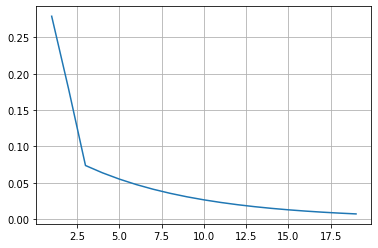

In [396]:
alfa = 0.05
print(requests)
print(np.average(requests))
print(np.average(requests**2))
print(np.std(requests))
r = 10
m = divide_requests(requests, r)
param = estimate_param(m)
Q = prob_req_param(param)

x = np.arange(1, r - 1)
p = []
for i in x:
    p.append(Q(i))
p.append(1 - sum(p))

chi_stat_req = Chi_squre_number(m, p)
chi_2 = chi2(r - 4)
chi_2_tres = chi_2.ppf(1 - alfa)

print("Chi2 statistic, Chi2 treshold val: " , round(chi_stat_req, 2) , round(chi_2_tres, 2))

x = np.arange(1, 20)
Fx = []
for i in x:
    Fx.append(Q(i))

plt.plot(x, Fx)
plt.grid()

#x = np.linspace(0, 10, 100)
#plt.plot(x, chi_2.cdf(x))
#plt.grid()

In [675]:
def Mix_Poisson_param(param):
    p , a1, a2 = param
    def Mix_Poisson(k):
        fact1 = 1
        fact2 = 1
        ret = 0
        if k==0:
            return 0
        else:
            for i in range(1, k):
                fact1 *= a1/i
                fact2 *= a2/i
            return p*np.exp(-a1) * fact1 + (1-p)*np.exp(-a2)*fact2
        #return p*np.exp(-a1)*(a1**k)/np.math.factorial(k) + (1-p)*np.exp(-a2)*(a2**k)/np.math.factorial(k)
    return Mix_Poisson

from scipy.optimize import fsolve

def GMM_mix_Poisson(sample):
    tmp = np.bincount(sample)
    tmp1 = tmp * np.arange(0, len(tmp))
    
    a1 = np.average(sample)
    #a2 = np.average(sample**2)
    #a3 = np.average(sample**3)
    sum1 = 0
    c = 0
    while(sum1 < sum(tmp)//2):
        sum1 += tmp[c]
        c += 1
    a2 = np.sum(tmp1[0:c]) / np.sum(tmp[0:c])
    a3 = np.sum(tmp1[c:len(tmp1)]) / np.sum(tmp[c:len(tmp)])
    equations1 = lambda x: (x*(a2 + 1) + (1 - x)*(a3 + 1) - a1)
    
    #equations = lambda x: (x[0]*(x[1] + 1) + (1 - x[0])*(x[2] + 1) - a1,
    #                      x[0]*(x[1]**2 + 3*x[1] + 1) + (1 - x[0])*(x[2]**2 + 3*x[2] + 1) - a2,
    #                      x[0]*(x[1]**3 + 6*x[1]**2 + 7*x[1] + 1) + (1 - x[0])*(x[2]**3 + 6*x[2]**2 + 7*x[2] + 1) - a3)
    
    #return fsolve(equations, (0.1, 1, 50))
    return [fsolve(equations1, 0.9), a2, a3]

In [696]:
def func_sum(inter, func):
    sum = 0 
    for i in np.arange(inter[0], inter[1] + 1): 
        sum += func(i)
    return sum

def divide_requests(req, r, func):
    
    tmp = np.bincount(requests)
    tmp = np.append(tmp, np.zeros(100))
    m = np.zeros(8)
    p = np.zeros(8)
    
    m[0] = np.sum(tmp[0:2])
    p[0] = func_sum([0,1], func)
    
    m[1] = np.sum(tmp[2:3])
    p[1] = func_sum([2,2], func)
    
    m[2] = np.sum(tmp[3:4])
    p[2] = func_sum([3,3], func)
    
    m[3] = np.sum(tmp[4:7])
    p[3] = func_sum([4,6], func)
    
    m[4] = np.sum(tmp[7:15])
    p[4] = func_sum([7,14], func)
    
    m[5] = np.sum(tmp[15:21])
    p[5] = func_sum([16,20], func)
    
    m[6] = np.sum(tmp[21:41])
    p[6] = func_sum([21,40], func)
    
    end = (len(tmp) - 1)
    m[7] = np.sum(tmp[41:end])
    p[7] = 1 - sum(p)#func_sum([41,end], func)
    return m, p

def Chi_squre_number(m, p):
    ret = 0
    r = len(m)
    n = np.sum(m)
    for i in range(0, r):
        ret += (m[i] - n*p[i])**2 / n*p[i]
    
    return ret

[array([0.59665891]), 1.627906976744186, 18.53153153153153]
[67. 43. 19. 38. 44.  9.  9. 11.]
[0.11714807 0.19070622 0.15522656 0.12975953 0.05120155 0.17258927
 0.1600365  0.02333231]
1.0
Chi2 statistic, Chi2 treshold val:  2.54 12.59 1.64


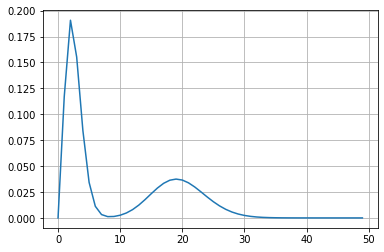

In [698]:
alfa = 0.05
param = GMM_mix_Poisson(requests)
P = Mix_Poisson_param(param)
print(param)
x = np.arange(0, 50)
Fx = []

for i in x:
    Fx.append(P(i))

plt.plot(x, Fx)
plt.grid()

#y = np.bincount(requests)
#print(y)
#print(requests)
m, p = divide_requests(requests, 10, P)
print(m)
print(p)
print(sum(p))
chi_stat_req = Chi_squre_number(m, p)
chi_2 = chi2(r - 4)
chi_2_tres1 = chi_2.ppf(1 - alfa)
chi_2_tres2 = chi_2.ppf(alfa)
print("Chi2 statistic, Chi2 treshold val: " , round(chi_stat_req, 2) , round(chi_2_tres1, 2), round(chi_2_tres2, 2))
